In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


keras.utils.image_dataset_from_directory can be used with labels as inferred if the images are placed in directory using the below convention
main_directory/  
...class_a/  
......a_image_1.jpg  
......a_image_2.jpg  
...class_b/  
......b_image_1.jpg  
......b_image_2.jpg  

In [3]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/dogs-vs-cats/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/kaggle/input/dogs-vs-cats/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [4]:
# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [5]:
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                        

In [7]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [8]:
history = model.fit(train_ds,epochs=4,validation_data=validation_ds)

Epoch 1/4
625/625 [==============================] - 77s 103ms/step - loss: 1.4299 - accuracy: 0.6048 - val_loss: 0.6547 - val_accuracy: 0.6784
Epoch 2/4
625/625 [==============================] - 58s 92ms/step - loss: 0.5516 - accuracy: 0.7203 - val_loss: 0.4641 - val_accuracy: 0.7846
Epoch 3/4
625/625 [==============================] - 57s 91ms/step - loss: 0.4573 - accuracy: 0.7875 - val_loss: 0.4812 - val_accuracy: 0.7792
Epoch 4/4
625/625 [==============================] - 57s 91ms/step - loss: 0.4173 - accuracy: 0.8145 - val_loss: 0.4292 - val_accuracy: 0.8022


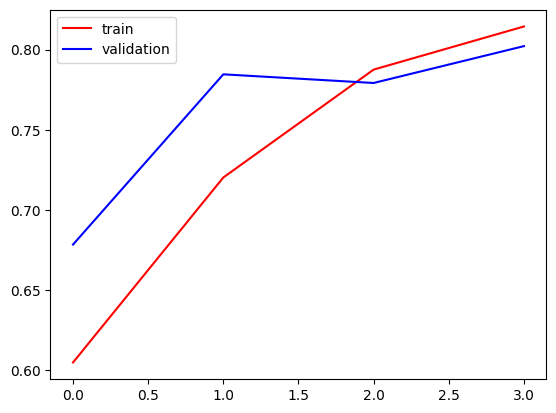

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

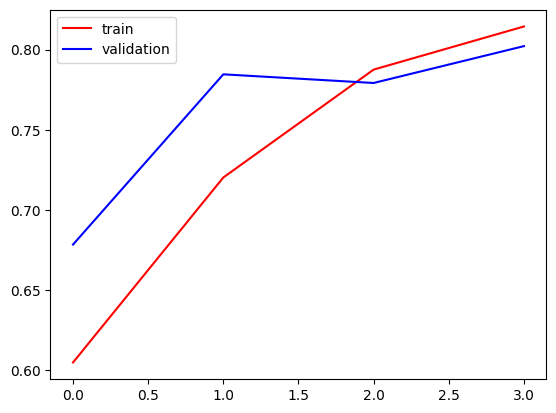

In [12]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [11]:
from keras.models import load_model

model.save('basic_dog_vs_cat_2.keras')  # creates a HDF5 file 'my_model.h5'


#### Next I will use a pre trained model to make the classification by utilizing the feature extraction property of pretrained model. Here the convolution layers are not frozen and their weights are not updated during training and only the top layer/dense layer weights are reupdated.

In [13]:
from keras.applications.vgg16 import VGG16

In [14]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3)
)

58889256/58889256 [==============================] - 0s 0us/step


In [15]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [16]:
pretrained_model = Sequential()

pretrained_model.add(conv_base)
pretrained_model.add(Flatten())
pretrained_model.add(Dense(256,activation='relu'))
pretrained_model.add(Dense(1,activation='sigmoid'))

In [18]:
pretrained_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               8388864   
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 23103809 (88.13 MB)
Trainable params: 23103809 (88.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Going to freeze the convolution layers

In [19]:
conv_base.trainable = False

In [20]:
pretrained_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [21]:
history2 = pretrained_model.fit(train_ds,epochs=5,validation_data=validation_ds)

Epoch 1/5
625/625 [==============================] - 140s 212ms/step - loss: 0.2842 - accuracy: 0.9007 - val_loss: 0.1616 - val_accuracy: 0.9330
Epoch 2/5
625/625 [==============================] - 130s 208ms/step - loss: 0.1293 - accuracy: 0.9488 - val_loss: 0.1644 - val_accuracy: 0.9312
Epoch 3/5
625/625 [==============================] - 130s 208ms/step - loss: 0.0944 - accuracy: 0.9632 - val_loss: 0.1595 - val_accuracy: 0.9364
Epoch 4/5
625/625 [==============================] - 131s 209ms/step - loss: 0.0617 - accuracy: 0.9777 - val_loss: 0.1836 - val_accuracy: 0.9368
Epoch 5/5
625/625 [==============================] - 131s 209ms/step - loss: 0.0461 - accuracy: 0.9826 - val_loss: 0.1808 - val_accuracy: 0.9364


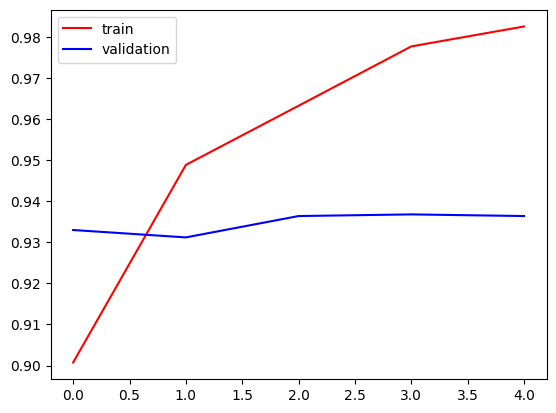

In [22]:
plt.plot(history2.history['accuracy'],color='red',label='train')
plt.plot(history2.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

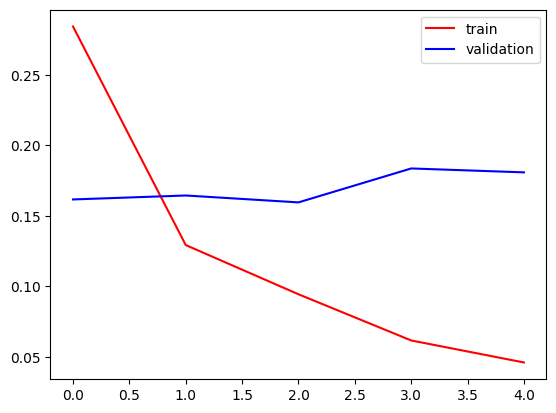

In [23]:
plt.plot(history2.history['loss'],color='red',label='train')
plt.plot(history2.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

#### Finally I will use data augmentation techniques along with the pre trained model to see if it increases the performance of the model for the same number of epochs

In [24]:
pretrained_model.save('basic_dog_vs_cat_vgg16.keras')

In [25]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [27]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        channel_shift_range = 0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/kaggle/input/dogs-vs-cats/train',
        target_size=(256, 256),
        batch_size=32,
        class_mode='binary') 

validation_generator = test_datagen.flow_from_directory(
        '/kaggle/input/dogs-vs-cats/test',
        target_size=(256, 256),
        batch_size=32,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [28]:
aug_model = Sequential()

aug_model.add(conv_base)
aug_model.add(Flatten())
aug_model.add(Dense(256,activation='relu'))
aug_model.add(Dense(1,activation='sigmoid'))

In [29]:
conv_base.trainable = False

In [30]:
aug_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [32]:
history3 = aug_model.fit_generator(
        train_generator,
        epochs=3,
        validation_data=validation_generator)

/tmp/ipykernel_47/2986132707.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3 = aug_model.fit_generator(


Epoch 1/3
625/625 [==============================] - 356s 567ms/step - loss: 0.3101 - accuracy: 0.8870 - val_loss: 0.1667 - val_accuracy: 0.9308
Epoch 2/3
625/625 [==============================] - 355s 568ms/step - loss: 0.1677 - accuracy: 0.9330 - val_loss: 0.1489 - val_accuracy: 0.9410
Epoch 3/3
625/625 [==============================] - 348s 557ms/step - loss: 0.1413 - accuracy: 0.9427 - val_loss: 0.1468 - val_accuracy: 0.9380


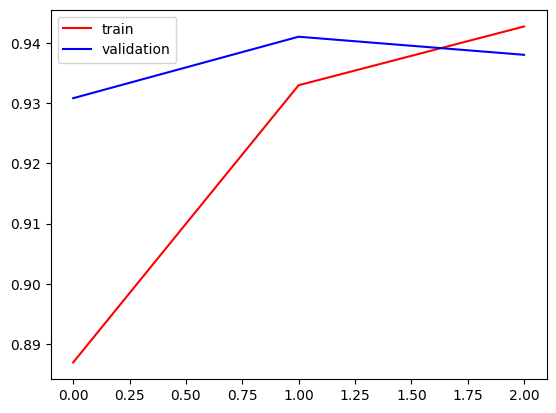

In [33]:


plt.plot(history3.history['accuracy'],color='red',label='train')
plt.plot(history3.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

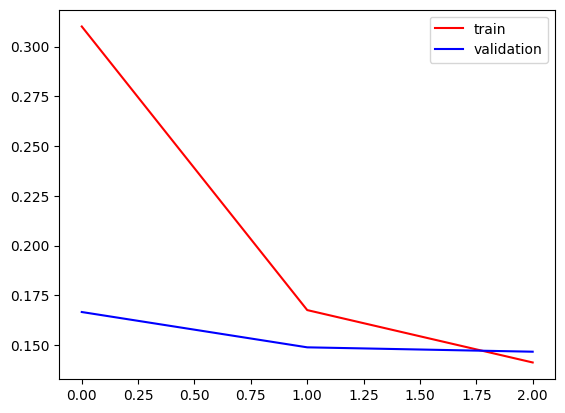

In [34]:
plt.plot(history3.history['loss'],color='red',label='train')
plt.plot(history3.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [35]:
aug_model.save('augmented_pretrained_dog_vs_cat.keras')  